## Introduction
This This A/B testing project evaluates the effectiveness of personalized push notifications in enhancing user engagement for a mobile application. The synthetic dataset simulates user interactions with the app following push notifications, tracking metrics such as app open rates and session durations. 

The experiment divides users into two groups:
- **Control Group:** Receives generic notifications.
- **Test Group:** Receives personalized notifications tailored to individual user behavior.

**Business Objective:**
The primary business objective is to determine whether personalized push notifications significantly increase user engagement compared to generic notifications. Higher engagement can lead to improved retention, increased session duration, and ultimately, greater user satisfaction.

### <u>Key Metrics</u>

To measure the impact of the push notifications, two key metrics have been identified:
1. **Open Rate:** The percentage of users who open the app after receiving a notification.
2. **Session Duration:** The amount of time a user spends in the app after opening it, indicating the depth of engagement.

### <u>Hypotheses Formulation</u>

To assess the effectiveness of the personalized push notifications, we formulate the following hypotheses:

**1. App Open Rate Hypothesis:**
- **Null Hypothesis (H0):** There is no difference in App Open Rate between the control and test groups.
- **Alternative Hypothesis (H1):** There is a significant difference in App Open Rate between the control and test groups.

**2. Average Session Duration Hypothesis:**
- **Null Hypothesis (H0):** There is no difference in Average Session Duration between the control and test groups.
- **Alternative Hypothesis (H1):** There is a significant difference in Average Session Duration between the control and test groups.




### <u>Step-By-Step Approach</u>

- Step 1: Importing Necessary Libraries and Data Preparation
    - Step 1.1 Creating a Large Synthetic Dataset
    - Step 1.2 Data Cleaning
    - Step 1.3: Visualizing the results
- Step 2: Calculating Key Metrics
- Step 3: Designing Experiment: Formulating Hypothesis
- Step 4: Statistical Test: Selecting the most suitable statistical tests
    - Step 4.1: Chi-square Test: calculating the required sample size
    - Step 4.2: Chi-square Test for App Open Rate
    - Step 4.3: Statistical Test for Session Duration
        1. Normality Check
        2. Homogeneity of Variances Check 
    - Step 4.4: Mann-Whitney U Test: calculating the required sample size
    - Step 4.5: Mann-Whitney U Test
    - Step 4.6: Visualization
- Step 5: Checking for practical significance or Investigating and Ensuring the robustness of the results
- Step 6: Overall Conclusion & Recommendation

## Step 1: Importing Necessary Libraries and Data Preparation

In [56]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.power import NormalIndPower
from scipy.stats import chi2_contingency
from scipy.stats import shapiro, levene
from scipy.stats import shapiro, probplot
from statsmodels.stats.power import TTestIndPower
from scipy.stats import mannwhitneyu

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline 

### Step 1.1 Creating a Large Synthetic Dataset

In [3]:
# set seed for reproducibility
np.random.seed(42)

# Parameters for synthetic data
num_users = 100000
group_choices = ['control', 'test']

#Average session duration in seconds
avg_session_duration = 300

# Standard deviation for session duration
std_dev_duration = 200

# 40% of users open the app after notification
open_rate = 0.4

**Need std_dev_duration:**

The inclusion of `std_dev_duration` is motivated by the need to understand variability in user engagement time. By tracking the standard deviation of session duration, you can see if engagement times are consistent or highly variable across users. High variability might indicate diverse usage patterns, which could inform more personalized engagement strategies. Understanding the spread in duration helps in clustering users into segments (e.g., highly engaged vs. moderately engaged vs. minimally engaged), leading to more targeted push notifications.

**Deciding 40% of Users Open the App After Notification:**

The 40% figure could have been derived from either historical data or industry benchmarks. If similar notifications had been sent previously, analysis of historical data could reveal that, on average, 40% of users opened the app within a certain time frame after receiving a notification. This kind of analysis helps in setting realistic expectations or there could be established benchmarks showing typical response rates for similar apps. For instance, if industry studies report that finance or e-commerce app notifications have an average open rate of around 40%, it would be reasonable to use this as a baseline.

**Note:**

Standard deviation is a measure of how spread out the values in a dataset are around the mean (average). A low standard deviation means that most user sessions are close in duration to the average, while a high standard deviation indicates that session durations vary widely. For app engagement, consistency can be important. If users generally spend a consistent amount of time per session, you might infer that they’re finding value in the app at a predictable level. However, high variability could suggest different types of engagement, with some users engaging deeply and others only briefly.

In [6]:
# Generate synthetic data
data = pd.DataFrame({
    'user_id': range(1, num_users + 1),
    'group': np.random.choice(group_choices, size=num_users),
    'send_time': [datetime(2024, 1, 1) + timedelta(minutes=np.random.randint(0, 1440)) for _ in range(num_users)],
    'open_time': [np.nan if np.random.rand() > open_rate else datetime(2024, 1, 1) + timedelta(minutes=np.random.randint(0, 1440))
                  for _ in range(num_users)],
    'session_duration': [np.nan if np.random.rand() > open_rate else max(0, np.random.normal(avg_session_duration, std_dev_duration))
                         for _ in range(num_users)]
})

# Add 'converted' column based on a 10% conversion rate for users who opened the app
conversion_rate = 0.1
data['converted'] = np.where((~data['open_time'].isna()) & (np.random.rand(num_users) < conversion_rate), 1, 0)

# Introduce some missing values
data.loc[data.sample(frac=0.05).index, 'session_duration'] = np.nan
data.loc[data.sample(frac=0.02).index, 'open_time'] = np.nan

# Add inactive users (no recent activity)
inactive_user_ids = data.sample(frac=0.1).index #  10% of users with no recent activity
data.loc[inactive_user_ids, 'open_time'] = np.nan
data.loc[inactive_user_ids, 'session_duration'] = np.nan
data.loc[inactive_user_ids, 'converted'] = 0 # set inactive users to not converted

# Add outlier session durations (users who accidently left the app open)
outlier_user_ids = data.sample(frac=0.05).index # 5% of users with outlier session durations
data.loc[outlier_user_ids, 'session_duration'] = data.loc[outlier_user_ids, 'session_duration'].fillna(0) + \
                                                 np.random.normal(10800, 1800, len(outlier_user_ids)) # Outliers around 3 hours

print(data.head())


   user_id    group           send_time           open_time  session_duration  \
0        1  control 2024-01-01 22:59:00 2024-01-01 00:03:00         307.82337   
1        2     test 2024-01-01 13:57:00 2024-01-01 12:10:00               NaN   
2        3  control 2024-01-01 08:55:00                 NaT               NaN   
3        4  control 2024-01-01 03:37:00                 NaT               NaN   
4        5  control 2024-01-01 22:57:00                 NaT               NaN   

   converted  
0          0  
1          0  
2          0  
3          0  
4          0  


In [7]:
data.head()


,user_id,group,send_time,open_time,session_duration,converted
0,1,control,2024-01-01 22:59:00,2024-01-01 00:03:00,307.82337,0
1,2,test,2024-01-01 13:57:00,2024-01-01 12:10:00,NaN,0
2,3,control,2024-01-01 08:55:00,NaT,NaN,0
3,4,control,2024-01-01 03:37:00,NaT,NaN,0
4,5,control,2024-01-01 22:57:00,NaT,NaN,0


In [8]:
data.shape

(100000, 6)

In [9]:
data.to_csv('data.csv', index=False)

### Step 1.2 Data Cleaning

**1. Handling Missing Values:**

   

In [10]:
pd.DataFrame(zip(data.isnull().sum(), data.isnull().sum()/len(data)), columns = ['count', 'proportion'], index=data.columns)

,count,proportion
user_id,0,0.00000
group,0,0.00000
send_time,0,0.00000
open_time,65083,0.65083
session_duration,62560,0.62560
converted,0,0.00000


- Missing values in `open_time` can be considered as users who did not open the notification.
- Missing values in `session_duration` can either be ignored or filled with zeros if they represent users with no session.

In [11]:
# Filling missing values in 'session_duration' with 0, assuming no session occurred for these users.
data['session_duration'].fillna(0, inplace=True)

# For 'open_time', we could either keep NaNs as they represent users who didn't open the notification
# or create an 'opened' binary feature to simplify analysis
data['opened'] = ~data['open_time'].isna()

In [12]:
pd.DataFrame(zip(data.isnull().sum(), data.isnull().sum()/len(data)), columns = ['count', 'proportion'], index=data.columns) 

,count,proportion
user_id,0,0.00000
group,0,0.00000
send_time,0,0.00000
open_time,65083,0.65083
session_duration,0,0.00000
converted,0,0.00000
opened,0,0.00000


In [13]:
data.head()

,user_id,group,send_time,open_time,session_duration,converted,opened
0,1,control,2024-01-01 22:59:00,2024-01-01 00:03:00,307.82337,0,True
1,2,test,2024-01-01 13:57:00,2024-01-01 12:10:00,0.00000,0,True
2,3,control,2024-01-01 08:55:00,NaT,0.00000,0,False
3,4,control,2024-01-01 03:37:00,NaT,0.00000,0,False
4,5,control,2024-01-01 22:57:00,NaT,0.00000,0,False


In [14]:
data['opened'].value_counts()

opened
False    65083
True     34917
Name: count, dtype: int64

In [15]:
# Drop 'open_time' as it is not needed for analysis
data.drop(columns=['open_time'], inplace=True)

In [16]:
data.head(2)

,user_id,group,send_time,session_duration,converted,opened
0,1,control,2024-01-01 22:59:00,307.82337,0,True
1,2,test,2024-01-01 13:57:00,0.00000,0,True


**2. Checking for outliers**

- **Outliers** in `session_duration` could be unusually long session times, likely due to users accidently leaving the app open.
- These can be identified statistical thresholds or by manually setting a cap.

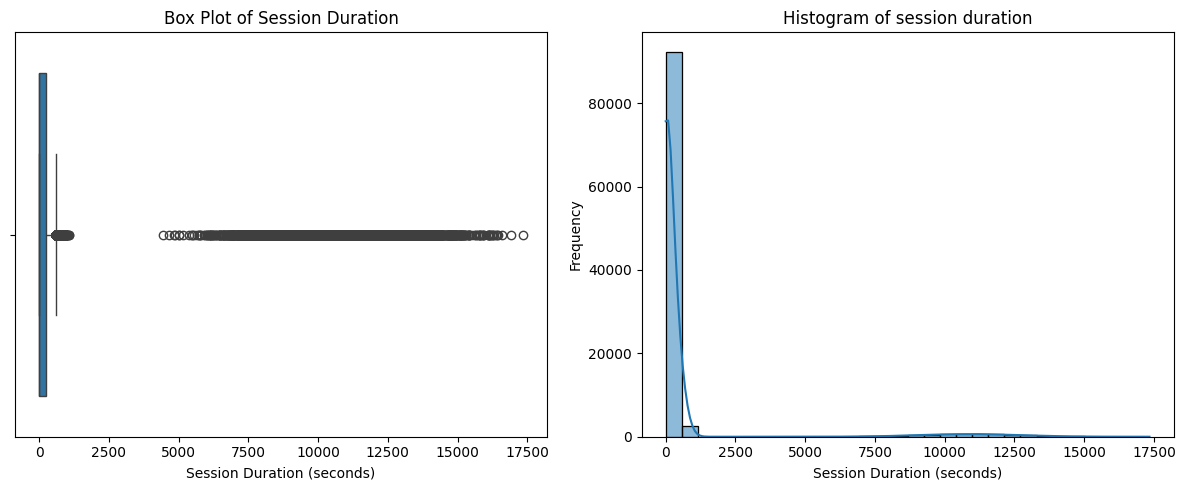

In [18]:
plt.figure(figsize=(12,5))

# Box plot for session duration
plt.subplot(1,2,1)
sns.boxplot(x=data['session_duration'])
plt.title('Box Plot of Session Duration')
plt.xlabel('Session Duration (seconds)')

# Histogram for session duration
plt.subplot(1,2,2)
sns.histplot(data['session_duration'], bins=30, kde=True)
plt.title("Histogram of session duration")
plt.xlabel("Session Duration (seconds)")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

These visuals provide insights into the session duration distribution. 

**1. Box Plot Interpretation:**
The box plot shows a tightly packed central range with a large number of outliers extending far to the right. This suggests that while most session durations are relatively short, a significant number of sessions have unusually high durations. The presence of numerous outliers on the right side suggests that some users might have accidentally left the app open, resulting in abnormally long session times.

**2. Histogram Interpretation**
The histogram shows a highly skewed distribution, with the majority of session durations clustered at the lower end. There’s a long tail stretching to the right, indicating that a small proportion of users have very high session durations. This distribution suggests that most sessions are short, with only a few lasting for an extended period (potentially due to leaving the app open unintentionally).

**Capping or Transforming the Data:** Capping the session duration to reduce the impact of outliers. Based on the business understanding, I have chosen the maximum threshold for session duration (1-2 hours) that will help cap extreme values.

In [20]:
duration_threshold = 7200 #cap at 2 hours (7200 seconds)
data['session_duration'] = np.where(data['session_duration'] > duration_threshold, duration_threshold, data['session_duration'])

**Recheck the Distribution**

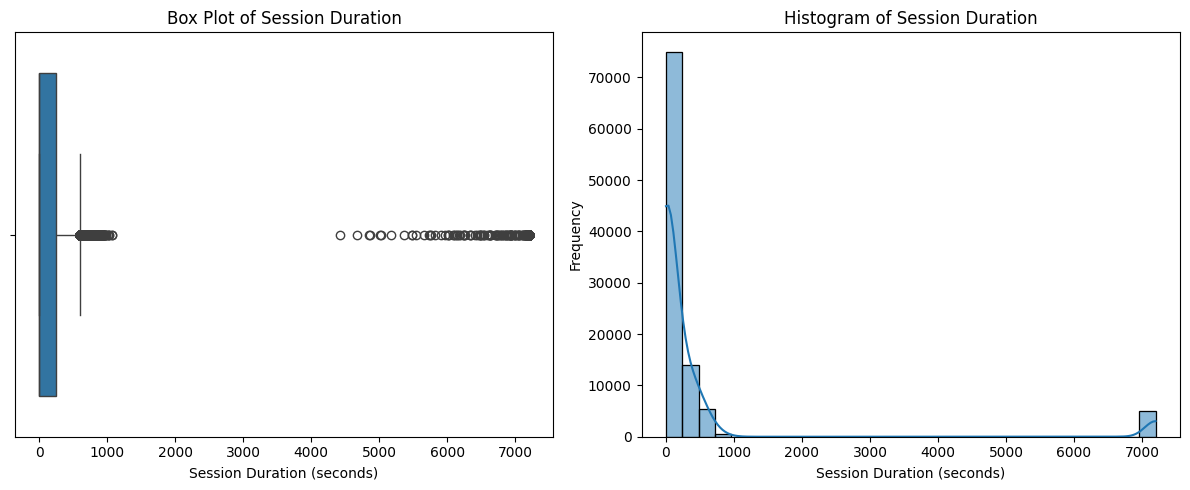

In [22]:
plt.figure(figsize=(12, 5))

# Box Plot for session duration
plt.subplot(1,2,1)
sns.boxplot(x=data['session_duration'])
plt.title('Box Plot of Session Duration')
plt.xlabel('Session Duration (seconds)')

# Histogram for session duration
plt.subplot(1,2,2)
sns.histplot(data['session_duration'], bins=30, kde=True)
plt.title("Histogram of Session Duration")
plt.xlabel("Session Duration (seconds)")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()
            

**Boxplot Interpretation**
- The box plot shows that outliers have been significantly reduced, with the maximum value now at the threshold (7200 seconds). There are still some points considered outliers within this capped range, but they’re much closer to the main data distribution.

- This suggests that the capping has successfully controlled the influence of extreme values, bringing the distribution closer to a normal range for analysis.

**Histogram Interpretation**
- The histogram now displays a clearer distribution with the majority of values concentrated on the left side, closer to zero, with a sharp drop-off as the values approach the 7200-second cap.

- This long tail up to the capped value indicates that while most session durations are short, a small portion of sessions still approach the cap. The distribution now appears more consistent, making the data easier to interpret and analyze.

In [23]:
print("Data after cleaning:")
data.head(5)

Data after cleaning:


,user_id,group,send_time,session_duration,converted,opened
0,1,control,2024-01-01 22:59:00,307.82337,0,True
1,2,test,2024-01-01 13:57:00,0.00000,0,True
2,3,control,2024-01-01 08:55:00,0.00000,0,False
3,4,control,2024-01-01 03:37:00,0.00000,0,False
4,5,control,2024-01-01 22:57:00,0.00000,0,False


In [24]:
data['opened'].value_counts(normalize=True)

opened
False    0.65083
True     0.34917
Name: proportion, dtype: float64

In [27]:
open_rate = data.groupby('group')['opened'].mean()
print("App Open Rate by Group:")
print(open_rate)

App Open Rate by Group:
group
control    0.349801
test       0.348541
Name: opened, dtype: float64


In [26]:
# Calculate the App Open Rate as a percentage
app_open_rate = data['opened'].mean() * 100
print(f"App Open Rate: {app_open_rate:.2f}%")

App Open Rate: 34.92%


In [31]:
avg_session_duration = data.groupby('group')['session_duration'].mean()
print("\nAverage Session Duration by group (seconds):")
print(avg_session_duration)


Average Session Duration by group (seconds):
group
control    455.671246
test       460.823757
Name: session_duration, dtype: float64


In [34]:
average_session_duration = data.loc[data['opened'], 'session_duration'].mean()
print(f"Average Session Duration (for users who opened the app): {average_session_duration:.2f} seconds")

Average Session Duration (for users who opened the app): 455.04 seconds


### Step 1.3: Visualizing the results

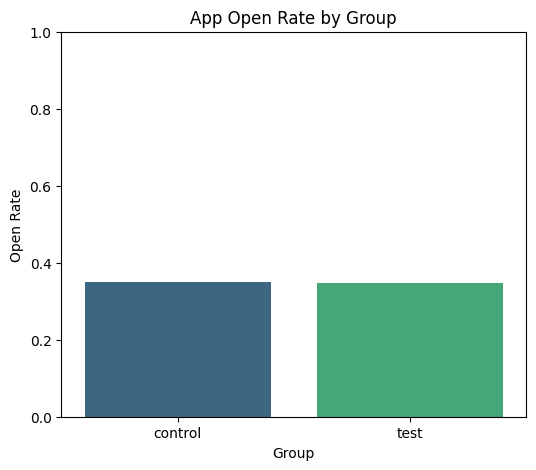

In [39]:
# Visualization 1: Bar Plot for App Open Rate by Group
plt.figure(figsize=(6, 5))
sns.barplot(x=open_rate.index, y=open_rate.values, palette='viridis')
plt.title("App Open Rate by Group")
plt.xlabel("Group")
plt.ylabel("Open Rate")
plt.ylim(0, 1)  # Scaling from 0 to 1 as 'opened' is binary
plt.show()

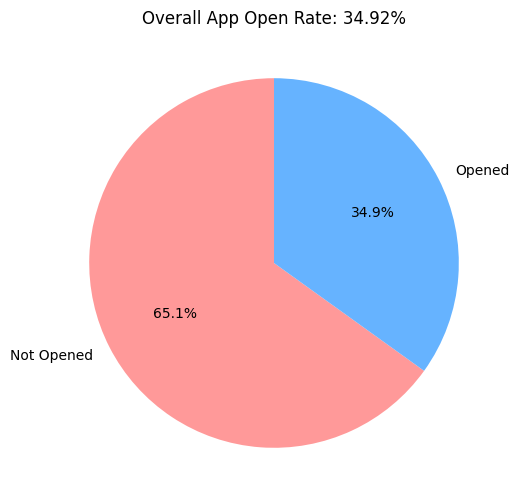

In [40]:
# Visualization 2: Pie Chart for Overall App Open Rate
opened_counts = data['opened'].value_counts(normalize=True)

plt.figure(figsize=(6, 6))
plt.pie(opened_counts, labels=["Not Opened", "Opened"], autopct='%1.1f%%', startangle=90, colors=["#ff9999","#66b3ff"])
plt.title(f"Overall App Open Rate: {app_open_rate:.2f}%")
plt.show()

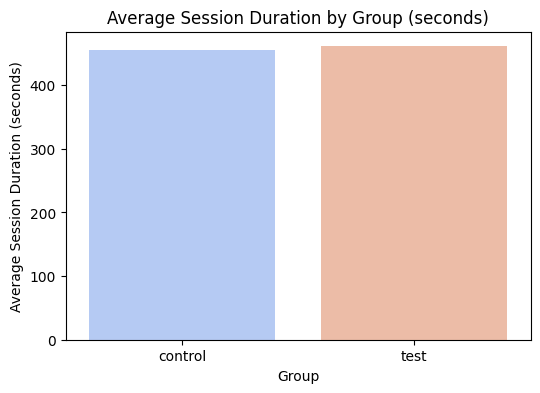

455.03942920582773

In [44]:
# Visualization 3: Bar Plot for Average Session Duration by Group
plt.figure(figsize=(6, 4))
sns.barplot(x=avg_session_duration.index, y=avg_session_duration.values, palette='coolwarm')
plt.title("Average Session Duration by Group (seconds)")
plt.xlabel("Group")
plt.ylabel("Average Session Duration (seconds)")
plt.show()

# Displaying the calculated average session duration for users who opened the app
average_session_duration

1. **App Open Rate by Group (Bar Plot):** This bar plot shows the open rate for the control and test groups, providing insights into user engagement based on the notification type.
2. **Overall App Open Rate (Pie Chart):** This pie chart displays the overall open rate across all users, showing the proportion of users who opened the app versus those who did not. The overall open rate is approximately 34.92%.
3. **Average Session Duration by Group (Bar Plot):** This bar plot illustrates the average session duration (in seconds) for users in each group. It helps compare engagement depth between control and test groups.

Additionally, the calculated average session duration for users who opened the app is approximately 455.03. This value gives a deeper understanding of how long engaged users stay in the app on average.

## Step 2: Calculating Key Metrics
- **App Open Rate:** Percentage of users who open the app after receiving a notification.
- **Session Duration:** Average time spent in the app after opening from a notification.

**Grouping data by 'group' (control vs. test)**

In [45]:
group_metrics = data.groupby('group').agg(app_open_rate=('opened', lambda x:x.mean()*100),
                                          average_session_duration=('session_duration', lambda x: x[x > 0].mean())
                                         ).reset_index()

print("Key Metrics by Group:")
print(group_metrics)

Key Metrics by Group:
     group  app_open_rate  average_session_duration
0  control      34.980075               1282.324881
1     test      34.854084               1314.093174


**The output provides a clear view of two important metrics by group:**

- App Open Rate: The percentage of users who opened the app.
- Average Session Duration: The average session duration, excluding users who did not open the app (i.e., those with a session duration of 0).

In regard to average_session_duration, we are only considering active sessions, providing a meaningful average session duration for both the control and test groups. This gives the true `average session duration` only for users who actually opened the app, providing a more accurate measure of engagement for each group.

## Step 3: Designing Experiment: Formulating Hypothesis

**Define Hypothesis:**
   
**1. App Open Rate Hypothesis:**
- **Null Hypothesis (H0):** There is no difference in App Open Rate between the control and test groups.
- **Alternative Hypothesis (H1):** There is a significant difference in App Open Rate between the control and test groups.

**2. Average Session Duration Hypothesis:**
- **Null Hypothesis (H0):** There is no difference in Average Session Duration between the control and test groups.
- **Alternative Hypothesis (H1):** There is a significant difference in Average Session Duration between the control and test groups.
        



## Step 4: Statistical Test: Selecting the most suitable statistical tests

**Reasoning for Choosing Chi-Square Test and Independent T-Test**

**1. Chi-square Test for App Open Rate:**
- Since App Open Rate is a binary outcome (either the user opened the app or not), we typically use the Chi-square test to compare proportions in categorical data between two independent groups (control and test).
- Assumption: Requires a sufficient sample size in each category.
- Alternative: If sample sizes are small, the Fisher’s Exact Test can be used as it does not rely on large sample assumptions.

**2. Independent T-test for Average Session Duration (not yet decided):**
- T-test assumes that the data is normally distributed within each group and that variances are equal (homogeneity of variances).
- Assumptions:
  - Normality of session duration within each group (control and test).
  - Homogeneity of variances between control and test groups.
- Alternative: If the normality or equal variance assumptions are violated, a non-parametric alternative like the Mann-Whitney U test (Wilcoxon rank-sum test) can be used.

**Important Note:**
- If both normality and homogeneity of variances assumptions are met: Use the Independent T-test.
- If normality is violated but variances are equal: Use the Mann-Whitney U test
- If variances are not equal: Use Welch’s T-test (for normally distributed data) or Mann-Whitney U test (for non-normally distributed data).

### Step 4.1: Chi-square Test: calculating the required sample size

Before conducting Chi-square test for App Open Rate, calculating the required sample size. is essential to ensure the test has enough statistical power to detect a meaningful difference between the control and test groups.

**calculating the required sample size for the Chi-square test for comparing App Open Rate (a binary outcome).**

1. Defining key parameters:
- Significance Level (α): Typically 0.05.
- Power (1 - β): Often set to 0.8 (80%).
- Effect Size (Cohen’s h): This is based on the expected difference between the control and test groups’ open rates. The effect size is crucial as it reflects the minimum difference you want to be able to detect.

2. Calculate Effect Size (Cohen’s h):
- Cohen’s h is used to quantify the difference in proportions between two groups.
- Given a baseline proportion (e.g., open rate in the control group) and a desired minimum detectable effect (difference in open rate between groups), Cohen’s h can be calculated as:

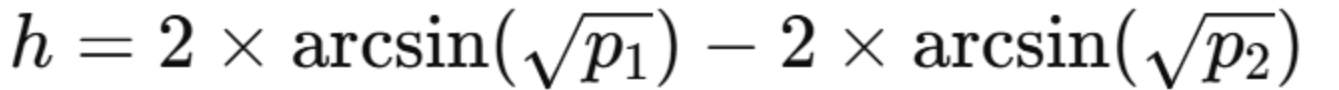

where p1is the proportion in one group (control) and p2 is the proportion in the other group (test).

3. Use `NormalIndPower` to Calculate Sample Size: NormalIndPower can be used to calculate the sample size for tests on proportions.


In [46]:
# Parameters for sample size calculation
alpha = 0.05 # significance level
power = 0.8 # desired power

# Define the baseline and target open rates
baseline_open_rate = 0.4 # control group open rate of 40% based on historical data.
target_open_rate = 0.5 # target open rate for test group of 50%, considering 10% increase in open rate to be meaningful.

# Calculate Cohen's h effect size
effect_size = 2 * (np.arcsin(np.sqrt(baseline_open_rate)) -  np.arcsin(np.sqrt(target_open_rate)))

# Create a power analysis object
power_analysis = NormalIndPower()

# Calculate the required sample size per group
sample_size_per_group = power_analysis.solve_power(effect_size=effect_size, alpha=alpha, power=power, alternative='two-sided')
total_sample_size = int(sample_size_per_group * 2) # Total sample size for both groups

print(f"Required sample size per group: {int(sample_size_per_group)}")
print(f"Total sample size (both groups): {total_sample_size}")
                   

                   

Required sample size per group: 387
Total sample size (both groups): 774


### Step 4.2: Chi-square Test for App Open Rate

To conduct the Chi-square test for App Open Rate, we’ll create a contingency table based on the number of users who opened the app (versus those who didn’t) in each group, then perform the Chi-square test to see if there’s a significant difference in open rates between the control and test groups.

In [48]:
# Create a contigency table for the counts of openers and non-openers in each group
contingency_table = pd.crosstab(data['group'], data['opened'])
print("Contingency Table:")
print(contingency_table)

Contingency Table:
opened   False  True 
group                
control  32469  17468
test     32614  17449


In [49]:
# Perform the Chi-square test
chi2_statistic, p_value, dof, expected = chi2_contingency(contingency_table)

# Output the results
print("\nChi-square test for App Open Rate:")
print("Chi-square statistic:", chi2_statistic)
print("Degrees of freedom:", dof)
print("p-value:", p_value)

# Interpretation
if p_value < 0.05:
    print("Result: There is a significant difference in App Open Rate between control and test groups.")
else: 
    print("Result: There is no significant difference in App Open Rate between control and test groups.")


Chi-square test for App Open Rate:
Chi-square statistic: 0.1691279622111286
Degrees of freedom: 1
p-value: 0.6808879808394416
Result: There is no significant difference in App Open Rate between control and test groups.


#### Interpretation of Results

1. **Contingency Table**:
   - The table shows that in the **control group**, 32,469 users did not open the app, while 17,468 did.
   - In the **test group**, 32,614 users did not open the app, while 17,449 did.
   - These counts are very close between the two groups, suggesting that the open rates for both groups are quite similar.

2. **Chi-square Statistic and p-value**:
   - The **Chi-square statistic** is **0.169**, indicating a small deviation between observed and expected counts.
   - The **p-value** is **0.681**, which is well above the typical significance level of 0.05. This high p-value means we fail to reject the null hypothesis.

3. **Conclusion**:
   - Since the **p-value > 0.05**, there is **no statistically significant difference** in the App Open Rate between the control and test groups.
   - This suggests that the notification strategy (generic vs. personalized messaging) did **not have a meaningful impact** on whether users opened the app.

The Chi-square test results indicate that the change from a generic message (control group) to a personalized message (test group) did not significantly affect the App Open Rate. Thus, the personalized messaging approach may not be more effective than the generic messaging approach in this scenario, as both produced very similar engagement!

### Step 4.3: Statistical test for Session Duration

**Implementing Normality and Homogeneity Tests to select statistical test**

**1. Normality Check:** Use the Shapiro-Wilk test to check if the session duration in each group is normally distributed.

**2. Homogeneity of Variances Check:** Use Levene’s Test to test if variances are equal across the two groups.

In [55]:
# Filter session duration for each group for users who opened the app
control_duration = data.loc[(data['group'] == 'control') & (data['opened']), 'session_duration']
test_duration = data.loc[(data['group'] == 'test') & (data['opened']), 'session_duration']

# 1. Normality Test (Shapiro-Wilk test) for each group
_, p_value_normality_control = shapiro(control_duration)
_, p_value_normality_test = shapiro(test_duration)

print("Normality Check:")
print("Control Group - p-value:", p_value_normality_control)
print("Test Group - p-value:", p_value_normality_test)

if p_value_normality_control < 0.05:
    print("Result: Session duration in the Control group is NOT normally distributed")
else:
    print("Result: Session duration in the Control group is normally distributed")

if p_value_normality_test < 0.05:
    print("Result: Session duration in the Test group is NOT normally distributed")
else:
    print("Result: Session duration in the Test group is normally distributed")


Normality Check:
Control Group - p-value: 0.0
Test Group - p-value: 0.0
Result: Session duration in the Control group is NOT normally distributed
Result: Session duration in the Test group is NOT normally distributed


In [63]:
# 2. Homogeneity of Variances (Levene’s Test)
_, p_value_levene = levene(control_duration, test_duration)
print("\nHomogeneity of Variances (Levene’s Test):")
print("p-value:", p_value_levene)

if p_value_levene < 0.05:
    print("Result: Variances are NOT equal between control and test groups")
else:
    print("Result: Variances are equal between control and test groups")


Homogeneity of Variances (Levene’s Test):
p-value: 0.6010214480676215
Result: Variances are equal between control and test groups


Given the results for **session duration**, here’s how we interpret the normality and homogeneity of variances tests and proceed with the appropriate statistical test:

**Interpretation of Test Results**

1. **Normality Check**:
   - Both the **control** and **test groups** have a **p-value of 0.0** for the normality test, indicating that **session duration is not normally distributed** in either group.
   - This violates the normality assumption required for a T-test.

2. **Homogeneity of Variances (Levene’s Test)**:
   - The **p-value for Levene’s test is 0.601**, which is greater than 0.05, suggesting that **variances are equal** between the control and test groups.
   - This meets the homogeneity of variances assumption.

**Visualizing the Results**

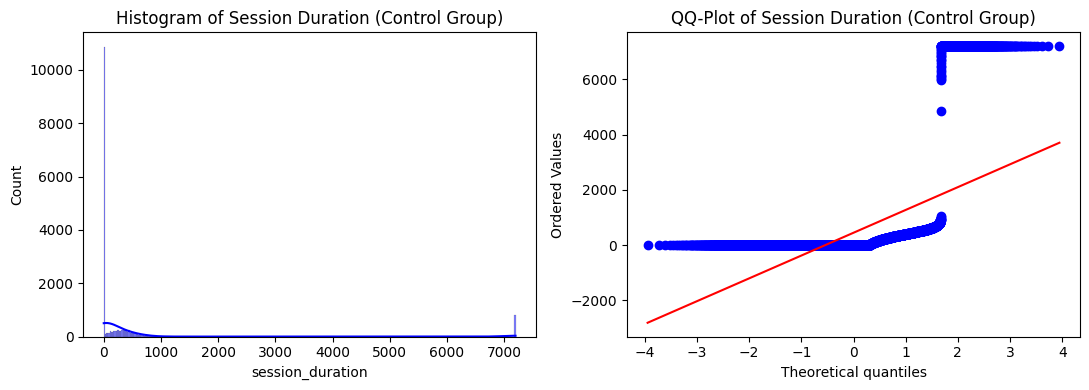

In [59]:
# QQ-Plot and Histogram for Control Group
plt.figure(figsize=(11, 4))

# Subplot 1: Histogram for Control Group
plt.subplot(1, 2, 1)
sns.histplot(control_duration, kde=True, color='blue')
plt.title("Histogram of Session Duration (Control Group)")

# Subplot 2: QQ-Plot for Control Group
plt.subplot(1, 2, 2)
probplot(control_duration, dist="norm", plot=plt)
plt.title("QQ-Plot of Session Duration (Control Group)")

plt.tight_layout()
plt.show()

1. **Histogram with KDE**:
   - The histogram shows a strong peak near zero and a long tail stretching to the right. This indicates a **right-skewed distribution**, where most users have very short or zero session durations, but a few have much longer sessions.
   - The shape does not resemble a bell curve, which is typical for a normal distribution.

2. **QQ-Plot**:
   - In the QQ-Plot, the points deviate significantly from the red line (theoretical quantiles for a normal distribution).
   - The lower and upper tails show extreme deviations, with points bending upward and away from the line. This is a clear indication of **non-normality**, as normally distributed data would have points that lie close to the line.

**Conclusion:**
The session duration for the control group is **not normally distributed**. The histogram and QQ-Plot both show strong evidence of skewness and deviation from normality, suggesting that a non-parametric statistical test might be more appropriate for analysis involving this data.

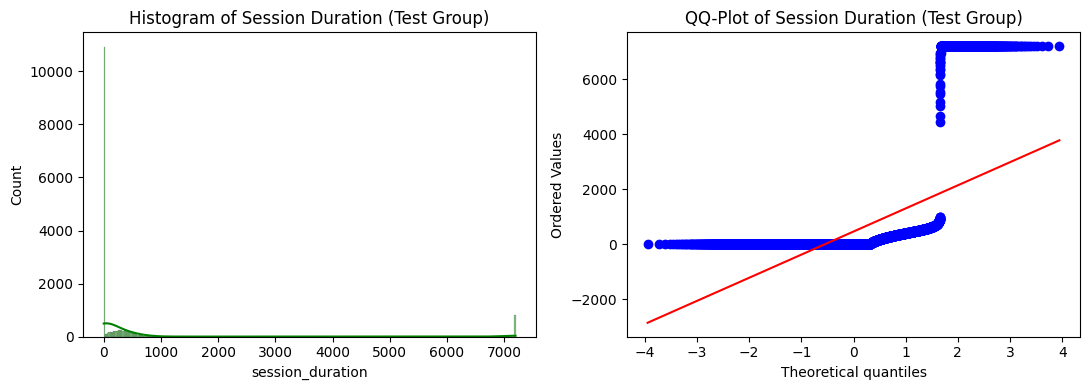

In [61]:
# QQ-Plot and Histogram for Test Group
plt.figure(figsize=(11, 4))

# Subplot 1: Histogram for Test Group
plt.subplot(1, 2, 1)
sns.histplot(test_duration, kde=True, color='green')
plt.title("Histogram of Session Duration (Test Group)")

# Subplot 2: QQ-Plot for Test Group
plt.subplot(1, 2, 2)
probplot(test_duration, dist="norm", plot=plt)
plt.title("QQ-Plot of Session Duration (Test Group)")

plt.tight_layout()
plt.show()

1. **Histogram with KDE**:
   - The histogram shows a large spike near zero, with a very long right tail extending toward higher session durations.
   - This suggests a **right-skewed distribution** where most session durations are close to zero, but there are a few values that are significantly higher.
   - A normal distribution would have a bell-shaped curve, which is not observed here.

2. **QQ-Plot**:
   - In the QQ-plot, the points deviate considerably from the red line, especially in the upper quantiles.
   - The points curve sharply upward in the upper-right corner, indicating that the distribution has a long right tail with extreme values (outliers).
   - Normally distributed data would have points that lie close to the red line. The deviation from this line confirms that the test group’s session duration data is not normally distributed.

**Conclusion**
The session duration data for the test group is **not normally distributed**. Both the histogram and QQ-plot show clear signs of right skewness, with a large concentration of low session durations and a few outliers. This non-normality suggests that a non-parametric statistical test might be more appropriate when analyzing session duration data for this group.

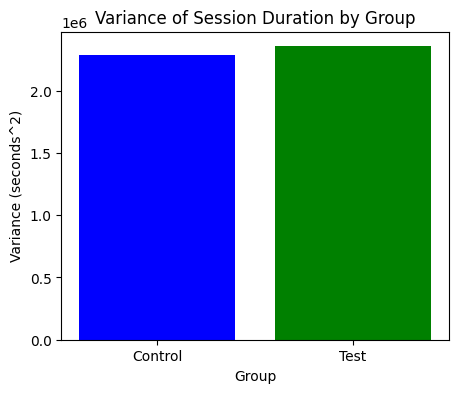

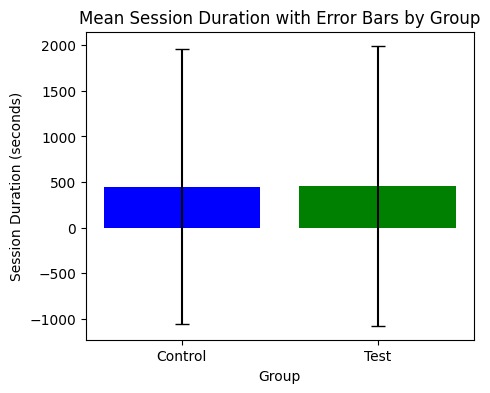

In [68]:
# Calculate variance for each group
control_variance = control_duration.var()
test_variance = test_duration.var()

# Bar Plot of Variances
plt.figure(figsize=(5, 4))
plt.bar(['Control', 'Test'], [control_variance, test_variance], color=['blue', 'green'])
plt.title("Variance of Session Duration by Group")
plt.ylabel("Variance (seconds^2)")
plt.xlabel("Group")
plt.show()

# Mean and standard deviation for each group
control_mean = control_duration.mean()
test_mean = test_duration.mean()
control_std = control_duration.std()
test_std = test_duration.std()

# Error Bar Plot
plt.figure(figsize=(5, 4))
plt.bar(['Control', 'Test'], [control_mean, test_mean], yerr=[control_std, test_std], capsize=5, color=['blue', 'green'])
plt.title("Mean Session Duration with Error Bars by Group")
plt.ylabel("Session Duration (seconds)")
plt.xlabel("Group")
plt.show()


#### 1. **Variance of Session Duration by Group (Bar Plot)**

- This bar plot shows the calculated variance of session durations for the control and test groups.
- Both bars have nearly equal heights, indicating that the variances (spread of session duration) are very similar between the two groups.
- The vertical axis represents the variance in seconds squared, which is a measure of how much the session durations vary within each group.
- Since the variances are close in value, this visual aligns with the result of Levene’s Test (p-value = 0.601), which suggested that **the variances are equal between the control and test groups**.

#### 2. **Mean Session Duration with Error Bars by Group**

- This bar plot displays the **mean session duration** for each group, with **error bars representing the standard deviation**.
- The bars represent the mean session duration for the control and test groups, which are similar in value.
- The error bars (extending up and down from each mean) show the spread or variability around the mean, based on one standard deviation.
- The similar lengths of the error bars between the two groups visually confirm that the standard deviations (and thus variances) are alike.
- This visualization supports the finding that the variability in session duration is consistent across both groups, further reinforcing the outcome of Levene’s Test that **the variances are homogeneous (equal)**.

  


1. **Normality Check**:
   - Both the **control** and **test groups** have a **p-value of 0.0** for the normality test, indicating that **session duration is not normally distributed** in either group.
   - This violates the normality assumption required for a T-test.

2. **Homogeneity of Variances (Levene’s Test)**:
   - The **p-value for Levene’s test is 0.601**, which is greater than 0.05, suggesting that **variances are equal** between the control and test groups.
   - This meets the homogeneity of variances assumption.

**Mann-Whitney U Test:**

Since the data is **not normally distributed**, a **non-parametric test** is more appropriate. Given that variances are equal, the **Mann-Whitney U Test** (also known as the Wilcoxon rank-sum test) is a suitable choice for comparing the median session durations between the two groups.



### Step 4.4: Mann-Whitney U Test: calculating the required sample size

Approximate Power Analysis for the Mann-Whitney U test estimates the required sample size using Cohen’s d effect size with TTestIndPower from the statsmodels library. This method, while not exact for non-parametric tests, provides a practical and commonly-used estimate for determining sample size.

In [69]:
# Define parameters
alpha = 0.05      # Significance level
power = 0.8       # Desired statistical power
effect_size = 0.5 # Medium effect size (Cohen's d)

# Initialize power analysis
power_analysis = TTestIndPower()

# Calculate required sample size per group
sample_size_per_group = power_analysis.solve_power(effect_size=effect_size, alpha=alpha, power=power, alternative='two-sided')
total_sample_size = int(sample_size_per_group * 2)  # Total sample size for both groups

# Display results
print(f"Approximate required sample size per group: {int(sample_size_per_group)}")
print(f"Approximate total sample size (both groups): {total_sample_size}")


Approximate required sample size per group: 63
Approximate total sample size (both groups): 127


In [70]:
# Adding a 20% buffer for added confidence
sample_size_with_buffer = int(sample_size_per_group * 1.2)
print(f"Recommended sample size per group with buffer: {sample_size_with_buffer}")


Recommended sample size per group with buffer: 76


Since this is an approximation for a non-parametric test, consider adding a 15-20% buffer to the calculated sample size to increase confidence in the test's power.

### Step 4.5: Mann-Whitney U Test

With the sample size confirmed, conducting the Mann-Whitney U test to compare the session durations between the control and test groups. This test will help determine if there is a statistically significant difference in session duration between the groups without assuming normality.

**Note:**
1. **Filter the Data**: Only include users who opened the app, as session duration is only meaningful for those who engaged with the notification.
2. **Run the Mann-Whitney U Test**: This test will compare the distributions of session durations between the two groups.

In [71]:
# Filter session duration for each group for users who opened the app
control_duration = data.loc[(data['group'] == 'control') & (data['opened']), 'session_duration']
test_duration = data.loc[(data['group'] == 'test') & (data['opened']), 'session_duration']

# Perform the Mann-Whitney U Test
u_statistic, p_value = mannwhitneyu(control_duration, test_duration, alternative='two-sided')

# Output the results
print("Mann-Whitney U Test for Average Session Duration:")
print("U-statistic:", u_statistic)
print("p-value:", p_value)

# Interpretation of results
if p_value < 0.05:
    print("Result: There is a significant difference in session duration between control and test groups.")
else:
    print("Result: There is no significant difference in session duration between control and test groups.")

Mann-Whitney U Test for Average Session Duration:
U-statistic: 153044654.0
p-value: 0.43292620379075875
Result: There is no significant difference in session duration between control and test groups.


The results of the **Mann-Whitney U Test** indicate the following:

**Interpretation of Results:**

1. **U-Statistic**: The U-statistic value is **153,044,654**, which is a measure of the rank-sum difference between the two groups.
2. **p-value**: The **p-value is 0.433**, which is much higher than the typical significance level of 0.05.

**Conclusion:**

Since the **p-value (0.433) is greater than 0.05**, we **fail to reject the null hypothesis**. This result indicates that there is **no statistically significant difference** in session duration between the control and test groups. In other words, the change from generic to personalized notifications did **not lead to a meaningful change** in how long users spent in the app after opening it.

#### Summary

- **App Open Rate**: Earlier analysis showed no significant difference in the App Open Rate between the control and test groups, indicating that personalized notifications did not improve the likelihood of users opening the app.
- **Session Duration**: The current Mann-Whitney U test results suggest that personalized notifications also did not increase the time users spent in the app.


### Step 4.6: Visualization


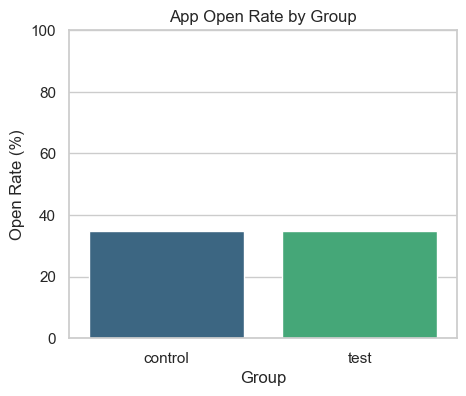

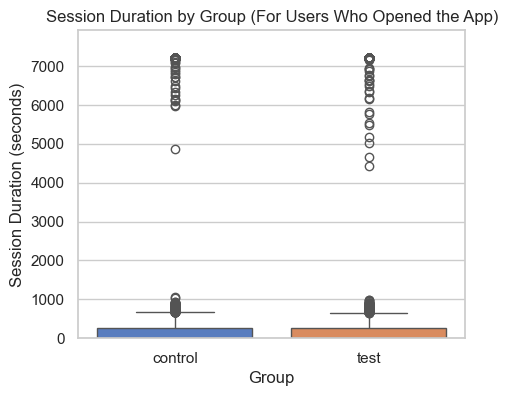

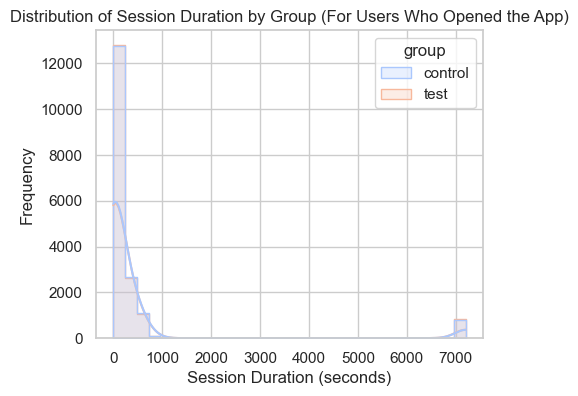

In [73]:
# Set the style for better aesthetics
sns.set(style="whitegrid")

# 1. Bar Plot for App Open Rate by Group
open_rate_data = data.groupby('group')['opened'].mean() * 100  # Calculate open rate in percentage
plt.figure(figsize=(5, 4))
sns.barplot(x=open_rate_data.index, y=open_rate_data.values, palette="viridis")
plt.title("App Open Rate by Group")
plt.xlabel("Group")
plt.ylabel("Open Rate (%)")
plt.ylim(0, 100)
plt.show()

# 2. Box Plot for Session Duration by Group (only for users who opened the app)
plt.figure(figsize=(5, 4))
sns.boxplot(x='group', y='session_duration', data=data[data['opened']], palette="muted")
plt.title("Session Duration by Group (For Users Who Opened the App)")
plt.xlabel("Group")
plt.ylabel("Session Duration (seconds)")
plt.ylim(0, data['session_duration'].max() * 1.1)  # Adjust y-limit for better view
plt.show()

# 3. Histogram with KDE for Session Duration by Group
plt.figure(figsize=(5, 4))
sns.histplot(data=data[data['opened']], x='session_duration', hue='group', kde=True, element="step", palette="coolwarm", bins=30)
plt.title("Distribution of Session Duration by Group (For Users Who Opened the App)")
plt.xlabel("Session Duration (seconds)")
plt.ylabel("Frequency")
plt.show()


#### Insights:

1. **App Open Rate by Group (Bar Plot)** 
- Both groups have a similar open rate, around 35%, indicating that personalized notifications (in the test group) did not significantly impact the likelihood of users opening the app compared to generic notifications in the control group.
- This suggests that the type of notification may not strongly influence whether users open the app, and other factors might be more influential in driving initial engagement.

2. **Session Duration by Group (Box Plot for Users Who Opened the App)**
- The box plot shows that session duration has a large range, with some users spending significantly more time than others in the app, but the distribution is highly skewed with most users clustered around lower values.
- This visualization supports the conclusion that while some users are very engaged (long session duration), the majority of users have shorter sessions, and the difference in session duration between the control and test groups is not substantial.

3. **Distribution of Session Duration by Group (Histogram for Users Who Opened the App)**
- Both distributions are highly skewed to the right, with the vast majority of session durations clustered at the lower end of the spectrum (close to zero) and a long tail extending to higher values.
- The similarity in distributions between the control and test groups suggests that personalized notifications did not lead to a significant change in how long users stayed in the app once they opened it.
- This skewed distribution indicates that, while some users engage deeply (long sessions), the majority engage only briefly, with similar behavior in both groups.


**Overall Engagement:** Both the open rate and session duration show similar patterns between the control and test groups, suggesting that the type of push notification (personalized vs. generic) did not have a substantial effect on user engagement in this case.

### Step 5: Checking for practical significance or Investigating and Ensuring the robustness of the results

In [88]:
# Number of bootstrap iterations
n_iterations = 1000

# Calculate the original difference in open rate between control and test groups
original_control_open_rate = data[data['group'] == 'control']['opened'].mean()
original_test_open_rate = data[data['group'] == 'test']['opened'].mean()
original_open_rate_diff = original_test_open_rate - original_control_open_rate

# Bootstrap sampling for App Open Rate
bootstrap_open_rate_diff = []
for _ in range(n_iterations):
    sample = data.sample(frac=1, replace=True)  # Resample with replacement
    control_open_rate = sample[sample['group'] == 'control']['opened'].mean()
    test_open_rate = sample[sample['group'] == 'test']['opened'].mean()
    bootstrap_open_rate_diff.append(test_open_rate - control_open_rate)

# Calculate confidence interval for open rate difference
lower_bound, upper_bound = np.percentile(bootstrap_open_rate_diff, [2.5, 97.5])
print(f"Original Difference in Open Rate: {original_open_rate_diff * 100:.2f}%")
print(f"95% Confidence Interval for Open Rate Difference: ({lower_bound * 100:.2f}%, {upper_bound * 100:.2f}%)")

# Calculate the original difference in median session duration for users who opened the app
original_control_median_duration = data[(data['group'] == 'control') & (data['opened'])]['session_duration'].median()
original_test_median_duration = data[(data['group'] == 'test') & (data['opened'])]['session_duration'].median()
original_session_duration_diff = original_test_median_duration - original_control_median_duration

# Bootstrap sampling for Session Duration
bootstrap_session_duration_diff = []
for _ in range(n_iterations):
    sample = data[data['opened']].sample(frac=1, replace=True)  # Only for users who opened
    control_median = sample[sample['group'] == 'control']['session_duration'].median()
    test_median = sample[sample['group'] == 'test']['session_duration'].median()
    bootstrap_session_duration_diff.append(test_median - control_median)

# Calculate confidence interval for session duration difference
lower_bound, upper_bound = np.percentile(bootstrap_session_duration_diff, [2.5, 97.5])
print(f"Original Difference in Session Duration (Median): {original_session_duration_diff:.2f} seconds")
print(f"95% Confidence Interval for Session Duration Difference: ({lower_bound:.2f} seconds, {upper_bound:.2f} seconds)")


Original Difference in Open Rate: -0.13%
95% Confidence Interval for Open Rate Difference: (-0.74%, 0.43%)
Original Difference in Session Duration (Median): 0.00 seconds
95% Confidence Interval for Session Duration Difference: (0.00 seconds, 0.00 seconds)


- In the App Open Rate bootstrap sampling, I am calculating  the mean open rate for both control and test groups, which provides the average proportion of users who opened the app in each group.
- In the Session Duration bootstrap sampling, I am calculating the median session duration for each group. The median is a measure of the central tendency that is less affected by extreme values (outliers) than the mean.
- Since session duration is typically highly skewed (with many short sessions and a few very long ones), using the median for session duration is likely to produce different results compared to using the mean. The median gives a more robust measure in the presence of skewness and outliers, often resulting in narrower confidence intervals.

**Summary:**
- Mean (Open Rate) vs. Median (Session Duration): The mean is used for the open rate because it’s straightforward with binary data, while the median is used for session duration to reduce the influence of outliers.
- Subset of Data for Session Duration: The session duration calculation is only for users who opened the app, which changes the sample distribution.
- Impact of Skewness: The median is less sensitive to skewness, resulting in a narrower and potentially more stable confidence interval for session duration.

#### 1. **Open Rate Results**
   - **Original Difference in Open Rate**: -0.13%
     - This means that, in the original dataset, the test group had a slightly lower open rate than the control group by 0.13%.
   - **95% Confidence Interval for Open Rate Difference**: (-0.74%, 0.43%)
     - This confidence interval suggests that the true difference in open rates between the test and control groups could fall anywhere between -0.74% and 0.43%.
     - Since this interval includes zero, it implies that there is **no statistically significant difference** in open rates between the two groups.
     - The result is **not practically significant** either, as the effect size (less than 1%) is minimal and likely not impactful.

   **Interpretation**:
   - The bootstrap confidence interval includes zero, suggesting that any observed difference in open rate between the test and control groups could be due to random chance.
   - This means that the personalized notifications in the test group did not significantly impact the app open rate compared to generic notifications in the control group.

#### 2. **Session Duration Results**
   - **Original Difference in Session Duration (Median)**: 0.00 seconds
     - The median session duration difference between the test and control groups is exactly zero seconds in the original data, meaning there was no observed difference in median session duration.
   - **95% Confidence Interval for Session Duration Difference**: (0.00 seconds, 0.00 seconds)
     - The confidence interval is also zero, suggesting there is **no variability** in the difference for median session duration between the two groups.
     - This result indicates that, across all bootstrap samples, there was no meaningful or measurable difference in median session duration.

   **Interpretation**:
   - Both the original difference and the confidence interval for session duration are zero, indicating that the median session duration is identical for the control and test groups.
   - This implies that the personalized push notifications had no impact on how long users stayed in the app once they opened it.

## Step 6: Overall Conclusion & Recommendation

The results suggest that the **personalized push notifications in the test group did not lead to a significant or meaningful change** in either:
- The **app open rate** (no significant increase or decrease in the likelihood of opening the app).
- The **session duration** (no increase in the time spent in the app once opened).

Since the confidence intervals include zero (for open rate) or show no difference (for session duration), there is no statistical or practical justification to conclude that the personalized notifications had any effect. 

#### Recommendation

Based on these findings:
- **No changes** to the current notification strategy are needed based on this A/B test.
- Future experiments could explore other notification strategies (e.g., different message content, timing, or frequency) to see if they impact user engagement more effectively.

In [ ]:
####################################################End-of-code################################################################